In [54]:
import numpy as np
import pandas as pd

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp

import qaoa_pennylane as qml_qaoa
from qiskit_optimization.converters import QuadraticProgramToQubo


In [57]:
data = pd.read_csv("data/cost_04_04.csv")
data

,p,i,j,Cost
0,2,1,2,1.72
1,2,1,3,1.65
2,2,1,4,0.31
3,2,2,3,0.68
4,2,2,4,0.41
5,2,3,4,1.14
6,3,1,2,5.82
7,3,1,3,5.57
8,3,1,4,1.04
9,3,2,3,2.28


In [58]:
parts = np.arange(1,data['p'].max()+1)

sites = np.arange(1,data['j'].max()+1)

print(f'Parts: {parts}')
print(f'Sites: {sites}')

M = len(parts)
N = len(sites)

Parts: [1 2 3 4]
Sites: [1 2 3 4]


In [59]:
from docplex.mp.model import Model

mdl = Model("docplex model")

# sites = [1, 2, 3, 4, 5, 6, 7]
# parts = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Create variables programmatically
var = {}
for i in parts:
    for j in sites:
        var_name = f"x_{i}_{j}"
        var[var_name] = mdl.binary_var(var_name)

In [62]:
len(var), var

(16,
 {'x_1_1': docplex.mp.Var(type=B,name='x_1_1'),
  'x_1_2': docplex.mp.Var(type=B,name='x_1_2'),
  'x_1_3': docplex.mp.Var(type=B,name='x_1_3'),
  'x_1_4': docplex.mp.Var(type=B,name='x_1_4'),
  'x_2_1': docplex.mp.Var(type=B,name='x_2_1'),
  'x_2_2': docplex.mp.Var(type=B,name='x_2_2'),
  'x_2_3': docplex.mp.Var(type=B,name='x_2_3'),
  'x_2_4': docplex.mp.Var(type=B,name='x_2_4'),
  'x_3_1': docplex.mp.Var(type=B,name='x_3_1'),
  'x_3_2': docplex.mp.Var(type=B,name='x_3_2'),
  'x_3_3': docplex.mp.Var(type=B,name='x_3_3'),
  'x_3_4': docplex.mp.Var(type=B,name='x_3_4'),
  'x_4_1': docplex.mp.Var(type=B,name='x_4_1'),
  'x_4_2': docplex.mp.Var(type=B,name='x_4_2'),
  'x_4_3': docplex.mp.Var(type=B,name='x_4_3'),
  'x_4_4': docplex.mp.Var(type=B,name='x_4_4')})

In [63]:
# phi  = [(2, 1),(3, 1),(4, 1),(5, 2),(6, 2),(7, 2),(8, 3),(9, 4),(10, 4)]
# psi = [(2, 3),(2, 4),(3, 4),(5, 6),(5, 7),(6, 7),(9, 10)]

phi = [(2, 1),(3, 2),(4, 2)]
# edges = [(1, 2, 1.0), (2, 3, 1.0), (2, 4, 1.0)]

In [64]:
#C
expr = 0
for (r,s) in phi:
    temp = data[data['p']==r]
    for site in sites:
        expr += temp.iloc[site-1,3] * var.get('x_'+str(r)+'_'+str(temp.iloc[site-1,1])) * var.get('x_'+str(s)+'_'+str(temp.iloc[site-1,2]))

In [65]:
print(expr)

1.720x_1_2*x_2_1+1.650x_1_3*x_2_1+0.680x_1_3*x_2_2+0.310x_1_4*x_2_1+5.820x_2_2*x_3_1+8.450x_2_2*x_4_1+5.570x_2_3*x_3_1+2.280x_2_3*x_3_2+8.090x_2_3*x_4_1+3.310x_2_3*x_4_2+1.040x_2_4*x_3_1+1.500x_2_4*x_4_1


In [66]:
#C1
expr1 = 0
for part in range(2,M+1):
    for site in sites:
        expr1 += -2 * var.get('x_'+str(part)+'_'+str(site)) * var.get('x_'+str(part)+'_'+str(site))
        for site2 in range(site+1,N+1):
            expr1 += var.get('x_'+str(part)+'_'+str(site)) * var.get('x_'+str(part)+'_'+str(site2))

In [67]:
expr1

docplex.mp.quad.QuadExpr(-2x_2_1^2+x_2_1*x_2_2+x_2_1*x_2_3+x_2_1*x_2_4-2x_2_2^2+x_2_2*x_2_3+x_2_2*x_2_4-2x_2_3^2+x_2_3*x_2_4-2x_2_4^2-2x_3_1^2+x_3_1*x_3_2+x_3_1*x_3_3+x_3_1*x_3_4-2x_3_2^2+x_3_2*x_3_3+x_3_2*x_3_4-2x_3_3^2+x_3_3*x_3_4-2x_3_4^2-2x_4_1^2+x_4_1*x_4_2+x_4_1*x_4_3+x_4_1*x_4_4-2x_4_2^2+x_4_2*x_4_3+x_4_2*x_4_4-2x_4_3^2+x_4_3*x_4_4-2x_4_4^2)

In [68]:
#C2
expr2 = 0
for (r,s) in phi:
    for site in sites:
        expr2 += var.get('x_'+str(r)+'_'+str(site)) * var.get('x_'+str(s)+'_'+str(site))

In [69]:
expr2

docplex.mp.quad.QuadExpr(x_1_1*x_2_1+x_1_2*x_2_2+x_1_3*x_2_3+x_1_4*x_2_4+x_2_1*x_3_1+x_2_1*x_4_1+x_2_2*x_3_2+x_2_2*x_4_2+x_2_3*x_3_3+x_2_3*x_4_3+x_2_4*x_3_4+x_2_4*x_4_4)

In [70]:
psi = [(3, 4)]

In [71]:
#C3
expr3 = 0
for (r,s) in psi:
    for site in sites:
        expr3 += var.get('x_'+str(r)+'_'+str(site)) * var.get('x_'+str(s)+'_'+str(site))

In [72]:
expr3

docplex.mp.quad.QuadExpr(x_3_1*x_4_1+x_3_2*x_4_2+x_3_3*x_4_3+x_3_4*x_4_4)

In [73]:
expr_final = expr + 1*expr1 + 1*expr2 + 1*expr3

In [74]:
# expr_final
mdl.minimize(expr_final)
print(mdl.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex model

Minimize
 obj: [ 2 x_1_1*x_2_1 + 3.440000000000 x_1_2*x_2_1 + 2 x_1_2*x_2_2
      + 3.300000000000 x_1_3*x_2_1 + 1.360000000000 x_1_3*x_2_2 + 2 x_1_3*x_2_3
      + 0.620000000000 x_1_4*x_2_1 + 2 x_1_4*x_2_4 - 4 x_2_1^2 + 2 x_2_1*x_2_2
      + 2 x_2_1*x_2_3 + 2 x_2_1*x_2_4 + 2 x_2_1*x_3_1 + 2 x_2_1*x_4_1
      - 4 x_2_2^2 + 2 x_2_2*x_2_3 + 2 x_2_2*x_2_4 + 11.640000000000 x_2_2*x_3_1
      + 2 x_2_2*x_3_2 + 16.900000000000 x_2_2*x_4_1 + 2 x_2_2*x_4_2 - 4 x_2_3^2
      + 2 x_2_3*x_2_4 + 11.140000000000 x_2_3*x_3_1 + 4.560000000000 x_2_3*x_3_2
      + 2 x_2_3*x_3_3 + 16.180000000000 x_2_3*x_4_1 + 6.620000000000 x_2_3*x_4_2
      + 2 x_2_3*x_4_3 - 4 x_2_4^2 + 2.080000000000 x_2_4*x_3_1 + 2 x_2_4*x_3_4
      + 3 x_2_4*x_4_1 + 2 x_2_4*x_4_4 - 4 x_3_1^2 + 2 x_3_1*x_3_2
      + 2 x_3_1*x_3_3 + 2 x_3_1*x_3_4 + 2 x_3_1*x_4_1 - 4 x_3_2^2
      + 2 x_3_2*x_3_3 + 2 x_3_2*x_3_4 + 2 x_3_2*x_4_2 - 4 x_3_3^2
  

In [75]:
# model.minimize(Q)   
problem = from_docplex_mp(mdl)

# QUBO formulation
converter = QuadraticProgramToQubo()
qubo = converter.convert(problem)

# Quadratic and Linear Coefficients
quadratics = qubo.objective.quadratic.coefficients
linears = qubo.objective.linear.coefficients

In [76]:
quadratics.toarray()

array([[ 0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  1.72,  1.  ,  0.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  1.65,  0.68,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.31,  0.  ,  0.  ,  1.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  , -2.  ,  1.  ,  1.  ,  1.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  , -2.  ,  1.  ,  1.  ,  5.82,
         1.  ,  0.  ,  0.  ,  8.45,  1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -2.  ,  1.  ,  5.57,
         2.28,  1.  ,  0.  ,  8.09,  3.31,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -2.  ,  1.04,
         0.  ,  0.  ,  1. 

In [77]:
linears.toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [78]:
result = qml_qaoa.qaoa(quadratics ,linears ,qubo ,layers=5)


Elapsed time for QAOA: 10.975088596343994 seconds


In [80]:
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

In [85]:
2**16

65536

In [83]:
result

{'0000000000000101': 1,
 '0000000000011100': 1,
 '0000000001000100': 1,
 '0000000001101101': 1,
 '0000000001110010': 1,
 '0000000010010000': 1,
 '0000000010111110': 1,
 '0000000011001011': 1,
 '0000000011011101': 1,
 '0000000100000011': 1,
 '0000000100010100': 1,
 '0000000100011010': 1,
 '0000000100111000': 1,
 '0000000100111010': 2,
 '0000000101000100': 1,
 '0000000101011011': 1,
 '0000000110000111': 1,
 '0000000111100111': 1,
 '0000000111101101': 1,
 '0000001000010101': 1,
 '0000001000010111': 1,
 '0000001000110110': 1,
 '0000001010010011': 1,
 '0000001010011111': 1,
 '0000001010110011': 1,
 '0000001100010110': 1,
 '0000001100011011': 1,
 '0000001110000000': 1,
 '0000001110000101': 1,
 '0000001110011011': 1,
 '0000001110100001': 1,
 '0000001111100001': 1,
 '0000001111111010': 1,
 '0000010000000100': 1,
 '0000010000101101': 1,
 '0000010001011110': 1,
 '0000010001101011': 1,
 '0000010011010111': 1,
 '0000010011100011': 2,
 '0000010011111011': 1,
 '0000010100010111': 1,
 '00000101000111

<function matplotlib.pyplot.show(close=None, block=None)>

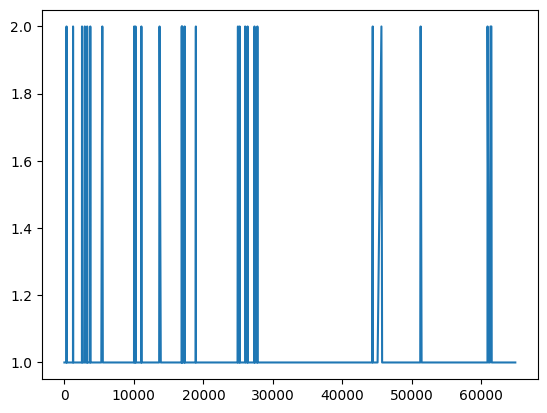

In [81]:
x = []
y = []
for i in result.keys():
    x.append(int(i,2))
    y.append(result[i])

plt.plot(x,y)
plt.show

In [86]:
best = qml_qaoa.find_most_common_solutions(result, 1)

In [87]:
best[0]

'0000000100111010'

In [88]:
n = N*M
qubo_cost = []
for i in range(2**n):
    qubo_cost.append(qubo.objective.evaluate(np.array(list(bin(i)[2:].zfill(n)),dtype="int")))

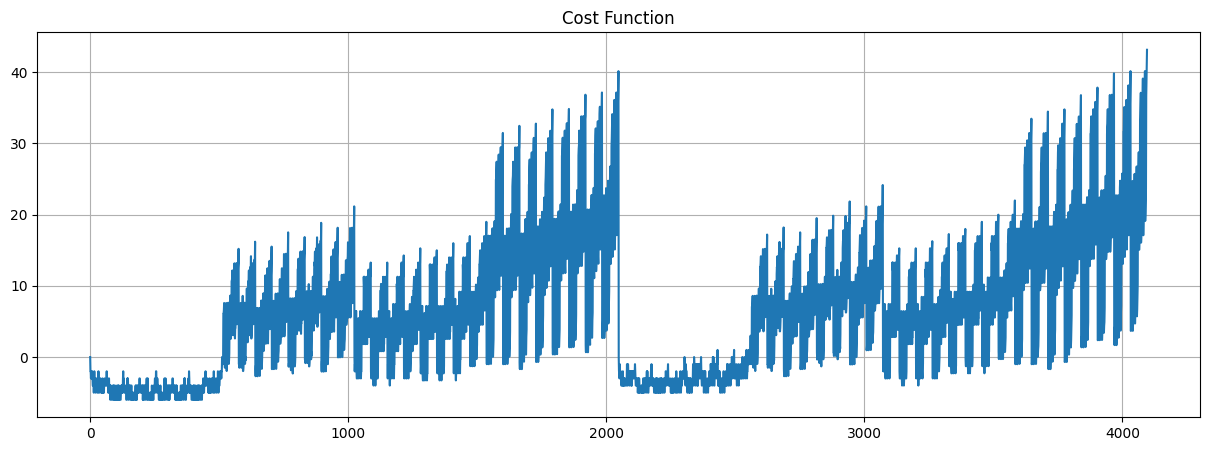

In [35]:
plt.figure(figsize=(15,5))
plt.plot(qubo_cost)
plt.title("Cost Function")
plt.grid()

In [37]:
# Graph plotting function.
def draw_graph(G, colors, pos):
    default_axes = plt.axes()
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")


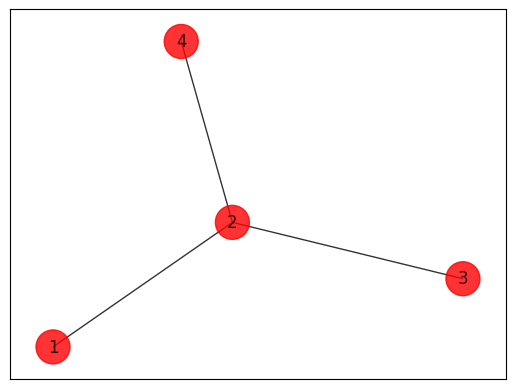

In [53]:
# Initializing a Graph Instance.

# Generating a graph of 4 nodes
# Nodes in the Graph.
n = 5  # Number of nodes in graph
G4 = nx.Graph()
G4.add_nodes_from(np.arange(1, n+1, 1))

# Edges in the Graph.
edges = [(1, 2, 1.0), (2, 3, 1.0), (2, 4, 1.0)]
G4.add_weighted_edges_from(edges)

# Colors and Positions for displaying the Graph.
colors = ["r" for node in G4.nodes()]
pos_4 = nx.spring_layout(G4)

draw_graph(G4, colors,pos_4)

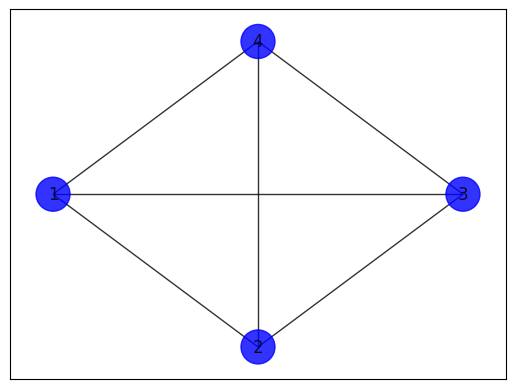

In [43]:
# Initializing a Graph Instance.

# Generating a graph of 4 nodes
# Nodes in the Graph.
n = 4  # Number of nodes in graph
G4 = nx.Graph()
G4.add_nodes_from(np.arange(1, n+1, 1))

# Edges in the Graph.
edges = [(1, 2, 1.0), (1, 3, 1.0), (2, 3, 1.0), (2, 4, 1.0), (4, 3, 1.0), (4, 1, 1.0)]
G4.add_weighted_edges_from(edges)

# Colors and Positions for displaying the Graph.
colors = ["b" for node in G4.nodes()]
pos_4 = nx.shell_layout(G4)

draw_graph(G4, colors, pos_4)

In [30]:
list(np.binary_repr(3, 12))

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1']

In [31]:
qubo.objective.evaluate(np.array(list(best[0]),dtype="int"))

10.93